# CS5500 : Reinforcement Learning

# Gantasala Naga Aneesh Ajaroy

# CS19BTECh11010

# Assignment № 4

## Problem 1 : Deep Q Learning

## Pong-v0 Environment

### Import Required Libraries

In [1]:
pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 30.6 MB/s 
     |████████████████████████████████| 1.6 MB 53.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616827 sha256=6283706355bac7a3dfb5128a5d452e02af66c5b84461f74aa3e8f2bb72892433
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=39fdf689f0b450899ad3fd4cc2af1b509672216516d9e3969c86d4d32b8d1ead
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    Found existing installati

In [2]:
import gym
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from matplotlib.colors import ListedColormap
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import cv2

# 1a) 

## Printing State and Action Spaces 

In [3]:
def load_env(name):
    env = gym.make(name)
    print("The environment {} is created".format(name))
    
    Observation_Space = env.observation_space
    Action_Space = env.action_space
    
    print("The Observation Space : {}".format(Observation_Space))
    states = Observation_Space.shape
    print("Observation represents the screen snapshot")

    
    print("The Action Space : {}".format(Action_Space))
    actions = Action_Space.n
    print("Number of valid Actions : {}".format(actions))
    print(env.unwrapped.get_action_meanings())

    return env
    

In [4]:
Environment = load_env('Pong-v0')

The environment Pong-v0 is created
The Observation Space : Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255

## Plotting Rewad Function using Random Agent

In [5]:
def reward_plot(env):
    
    Reward = []
    Action = []
    for ep in range(100):
        env.reset()
        while True:
            num_actions = env.action_space.n
            action_space = list(range(num_actions))
            A = random.sample(action_space,1)
            observation, reward, terminated,info = env.step(A[0])
            
            Action.append(A[0])
            Reward.append(reward)
            if terminated:
                break
                

    
    plt.scatter(Action, Reward)
    plt.xlabel('action')
    plt.ylabel('reward')
    plt.legend()
    plt.show()
        

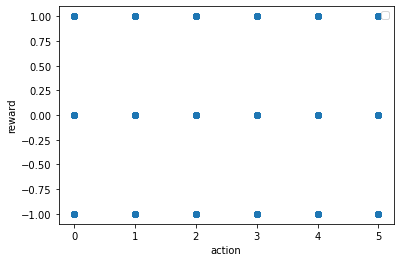

In [6]:
reward_plot(Environment)

# 1b)

## DQN Algorithm

### Deep Q Learning Network

In [7]:

def DQN(input_shape,num_actions,lr):
    
    X_input = Input(input_shape)
    X = X_input
    
    
    X = Conv2D(32, 8, strides=(4, 4), input_shape=input_shape, activation="relu", data_format="channels_first")(X)
    X = Conv2D(64, 4, strides=(2, 2), activation="relu", data_format="channels_first")(X)
    X = Conv2D(64, 3, strides=(1, 1), activation="relu", data_format="channels_first")(X)
    X = Flatten()(X)
    
    X = Dense(512, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(num_actions, activation="linear", kernel_initializer='he_uniform')(X)
    
    DQNet = Model(inputs = X_input, outputs = X)
    DQNet.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return DQNet
    

### Replay Buffer

In [8]:
class ReplayBuffer:
    
    def __init__(self, size, input_shape):
        self.size = size
        self.pos = 0
        self.state = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.action = np.zeros(self.size, dtype=np.int32)
        self.reward = np.zeros(self.size, dtype=np.float32)
        self.new_state = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.terminal = np.zeros(self.size, dtype=np.bool_)

    def store_tuples(self, S, A, R, NS, done):
        
        i = self.pos % self.size
        self.state[i] = S
        self.action[i] = A
        self.reward[i] = R
        self.new_state[i] = NS
        self.terminal[i] = done
        self.pos += 1

    def sample_buffer(self, batch_size):
        
        max_buffer = min(self.pos, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state[batch]
        action_batch = self.action[batch]
        reward_batch = self.reward[batch]
        new_state_batch = self.new_state[batch]
        done_batch = self.terminal[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

### Agent Class for Creating, Training and  Optimizing our RL Agent

In [9]:
class Agent:
    
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size):
        
        self.image_shape = (4,80,80)
        
        self.action_space = [i for i in range(num_actions)]
        
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        
        self.epsilon_decay = 0.00002
        self.min_epsilon = 0.02
        self.update_rate = 1000
        self.step_counter = 0
        
        self.buffer = ReplayBuffer(1000, self.image_shape)
        self.image_memory = np.zeros(self.image_shape)
        
        self.DQNET = DQN(self.image_shape,num_actions,lr)
        self.DQNET_Tar = DQN(self.image_shape,num_actions,lr)

    def store_tuple(self, state, action, reward, new_state, done):
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
        
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array(observation)
            actions = self.DQNET(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        return action
    

    def optimize(self):
        
        if self.buffer.pos < self.batch_size:
            return
        
        if self.step_counter % self.update_rate == 0:
            self.DQNET_Tar.set_weights(self.DQNET.get_weights())

        state_batch, action_batch, reward_batch, new_state_batch, done_batch = self.buffer.sample_buffer(self.batch_size)

        Q_pred = self.DQNET(state_batch)
        Q_nxt = self.DQNET_Tar(new_state_batch)
        Q_nxt_max = tf.math.reduce_max(Q_nxt, axis=1, keepdims=True).numpy()
        Q_Req = np.copy(Q_pred)

        
        for i in range(done_batch.shape[0]):
            temp = reward_batch[i]
            if not done_batch[i]:
                temp += self.discount_factor*Q_nxt_max[i]
            Q_Req[i, action_batch[i]] = temp
        self.DQNET.train_on_batch(state_batch, Q_Req)
        
        
        if self.epsilon > self.min_epsilon:
            self.epsilon = self.epsilon - self.epsilon*self.epsilon_decay
        else:
            self.epsilon = self.min_epsilon
        
        self.step_counter += 1
        
    def pre_process_image(self,observation):
        
        
        observation_crop = cv2.resize(observation, (80, 80), interpolation=cv2.INTER_CUBIC)
        observation_grey = cv2.cvtColor(observation_crop, cv2.COLOR_BGR2GRAY)
        observation_grey = np.array(observation_grey).astype(np.float32) / 255.0
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)
        self.image_memory[0,:,:] = observation_grey
        
        return np.expand_dims(self.image_memory, axis=0)
    
    
    
    
    def env_reset(self,env):
        observation = env.reset()
        for i in range(4):
            state = self.pre_process_image(observation)
        return state
        
        

    def train_model(self, env, num_episodes, mean_n):
        
        
        Eps_Reward = []
        N_Mean_Reward = []
        Best_Mean_Reward = []
        best_reward = -21.0
        success = 0
        Total_steps = []
        s = 0
        
        for i in range(num_episodes):
            terminated = False
            ep_reward = 0.0
            
            state = self.env_reset(env)
                
            while (not terminated):
                s += 1
                action = self.policy(state)
                observation, reward, terminated,info = env.step(action)
                ep_reward += reward
                observation = self.pre_process_image(observation)
                self.store_tuple(state, action, reward, observation, terminated)
                state = observation
                self.optimize()
                if terminated:
                    success += 1

            Eps_Reward.append(ep_reward)
            if i >= mean_n:
                present_mean = np.mean(Eps_Reward[-mean_n:])
                N_Mean_Reward.append(present_mean)
                best_reward = max(present_mean,best_reward)
                Best_Mean_Reward.append(best_reward)
                Total_steps.append(s)
            print("Step Number: {} \t Episode Number: {} \t Reward: {} \t Success: {}".format(s,i,ep_reward,success))
            
        

        plt.plot(Total_steps, N_Mean_Reward,label=str(mean_n)+"-mean Reward")
        plt.plot(Total_steps,Best_Mean_Reward,label="Best Mean Reward")
        plt.xlabel("Number of steps")
        plt.ylabel('reward')
        plt.title("Performance of Agent")
        plt.legend()
    
    
        return N_Mean_Reward,Best_Mean_Reward


## Plots of Learning Curve 

Step Number: 1217 	 Episode Number: 0 	 Reward: -20.0 	 Success: 1
Step Number: 2499 	 Episode Number: 1 	 Reward: -21.0 	 Success: 2
Step Number: 3640 	 Episode Number: 2 	 Reward: -20.0 	 Success: 3
Step Number: 4850 	 Episode Number: 3 	 Reward: -21.0 	 Success: 4
Step Number: 6125 	 Episode Number: 4 	 Reward: -19.0 	 Success: 5
Step Number: 7183 	 Episode Number: 5 	 Reward: -21.0 	 Success: 6
Step Number: 8574 	 Episode Number: 6 	 Reward: -20.0 	 Success: 7
Step Number: 9866 	 Episode Number: 7 	 Reward: -21.0 	 Success: 8
Step Number: 11050 	 Episode Number: 8 	 Reward: -21.0 	 Success: 9
Step Number: 12171 	 Episode Number: 9 	 Reward: -21.0 	 Success: 10
Step Number: 13425 	 Episode Number: 10 	 Reward: -20.0 	 Success: 11
Step Number: 14497 	 Episode Number: 11 	 Reward: -21.0 	 Success: 12
Step Number: 15689 	 Episode Number: 12 	 Reward: -20.0 	 Success: 13
Step Number: 16704 	 Episode Number: 13 	 Reward: -21.0 	 Success: 14
Step Number: 17771 	 Episode Number: 14 	 Rewar

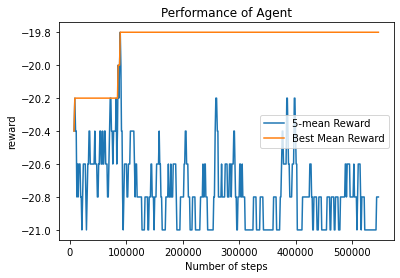

In [10]:
env = gym.make('Pong-v0')
num_episodes = 500
mean_n = 5
Train_Agent = Agent(lr=0.001, discount_factor=0.99, num_actions=6, epsilon=1.0, batch_size=8)

x,y = Train_Agent.train_model(env, num_episodes, mean_n)

# Beacuse of time and resource constraints, Training is not completed to the optimal state

# And alternate hyper parameters are not used